In [13]:
%matplotlib inline
import sys, os
sys.path.append("../")
import numpy as np
import scipy as sp
import numpy.linalg as nla
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.pylab as pl
from timeit import timeit
import ot
import ot.plot
from ot.datasets import make_1D_gauss as gauss
from drot.solver import drot, drot2, PDHG
from drot.proximal import *
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Optimal transport

In [10]:
def one_dimensional_gaussian_ot(n):
    t = np.arange(0, n)/n
    Gaussian = lambda t0, sigma: np.exp(-(t-t0)**2 / (2*sigma**2))
    normalize = lambda p: p / np.sum(p)
    sigma = 0.1;
    p = Gaussian(.75, sigma)
    q = Gaussian(.15, sigma)
    vmin = .02;
    p = normalize(p + np.max(p) * vmin)
    q = normalize(q + np.max(q) * vmin)
    [Y,X] = np.meshgrid(t,t)
    C = np.array((X-Y)**2, order='F')
    # C = np.array(np.abs(X-Y), order='F')
    return n, C, p, q

def two_dimensional_gaussian_ot(m, n):
    mu_s = np.array([0, 0.5])
    cov_s = np.array([[1, 0.5], [0.5, 1]])
    mu_t = np.array([4, 10])
    cov_t = np.array([[1, -.8], [-.8, 1]])
    xs = ot.datasets.make_2D_samples_gauss(m, mu_s, cov_s)
    xt = ot.datasets.make_2D_samples_gauss(n, mu_t, cov_t)
    p, q = np.ones((m,)) / m, np.ones((n,)) / n  
    C = np.array(ot.dist(xs, xt), order='F')
    C /= C.max()

    return m, n, C, p, q

Solve time:  0.1322770118713379
Solve time:  0.06894207000732422


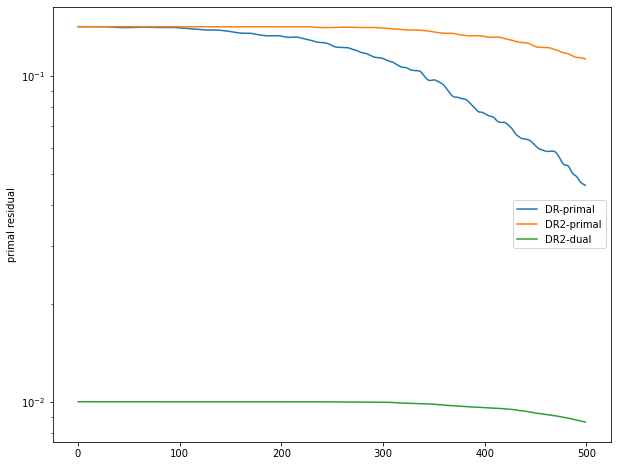

In [40]:
max_iters = 500
step = 0.1

m, n, C, p, q = two_dimensional_gaussian_ot(100, 100)
x0 = np.ones((m, n), order='F') / n
eta, tau = (1/(m+n))**0.5, (1/(m+n))**0.5

assert C.flags['F_CONTIGUOUS']   
assert x0.flags['F_CONTIGUOUS']   

proxf = lambda x, stz: trace_nonnegative_prox(x, C, stz)
proxg = lambda x, stz: generalized_doubly_stochastic_matrices_projection(x, p, q)
# proxg_ = lambda x, y, stz: primal_dual_trace_nonnegative_prox(x, C, y, stz)
# proxh = lambda x, xnew, y, stz: primal_dual_linear_prox(x, xnew, y, p, q, stz)

drout  = drot(x0, C, p, q, max_iters=max_iters, step=step, compute_r_primal=True, 
              compute_r_dual=True, adapt_stepsize=False, fixed_restart=False, 
              milestones=[100, 500, 1000], eps_abs=1e-10, eps_rel=1e-10, verbose=False)

dr2out  = drot2(x0, proxf, proxg, np.hstack((p,q)), max_iters, step=step, relaxation=1.0, compute_r_primal=True, 
              compute_r_dual=True, adapt_stepsize=False, fixed_restart=True, milestones=[100, 500, 1000], 
              eps_abs=1e-10, eps_rel=1e-10)
# cpout  = PDHG(x0, proxg_, proxh, max_iters, eta=eta, tau=tau, relaxation=1.0)

xopt = drout["sol"]
x2opt = dr2out["sol"]
# xopt_cp = cpout["sol"]

plt.figure(1, figsize=(10,8))
plt.plot(range(drout["num_iters"]), [r for r in drout['primal']], label='DR-primal')
# plt.plot(range(drout["num_iters"]), [r for r in drout['dual']], label='DR-dual')
plt.ylabel("primal residual") 
plt.yscale('log')
plt.legend()

plt.figure(1, figsize=(10,8))
plt.plot(range(dr2out["num_iters"]), [r for r in dr2out['primal']], label='DR2-primal')
plt.plot(range(dr2out["num_iters"]), [r for r in dr2out['dual']], label='DR2-dual')
plt.ylabel("primal residual") 
plt.yscale('log')
plt.legend()

# # plt.figure(2, figsize=(10,8))
# plt.plot(range(cpout["num_iters"]), [r for r in cpout['dual']], label='PDHG-dual')
# # plt.ylabel("primal residual") 
# plt.yscale('log')
# plt.legend()

In [ ]:
C_ = C.copy()
G0 = ot.emd(p, q, C_)
Gs = ot.sinkhorn(p, q, C_, 1e-3, verbose=False)
nla.norm(xopt - G0, ord='fro'),\
nla.norm(Gs - G0, ord='fro')

In [ ]:
np.sum(G0 >= 1e-14) 

In [ ]:
np.trace(xopt.T.dot(C)), np.trace(G0.T.dot(C_)), np.trace(Gs.T.dot(C_))

In [ ]:
pl.figure(1)
pl.imshow(xopt, interpolation='nearest')
pl.title('OT matrix DR')

pl.figure(2)
pl.imshow(G0, interpolation='nearest')
pl.title('OT matrix G0')

pl.figure(4)
pl.imshow(xopt_cp, interpolation='nearest')
pl.title('OT matrix PDHG')

pl.figure(3)
pl.imshow(Gs, interpolation='nearest')
pl.title('OT matrix Sinkhorn')

In [ ]:
pl.figure(3, figsize=(6, 4))
ot.plot.plot1D_mat(p, q, xopt.T, 'OT matrix DR')
# pl.title("---")

pl.figure(6, figsize=(6, 4))
ot.plot.plot1D_mat(p, q, G0, 'OT matrix LP')

pl.figure(9, figsize=(6, 4))
ot.plot.plot1D_mat(p, q, Gs, 'OT matrix Sinkhorn')
pl.show()

In [ ]:
def Sinkhorn(C, reg, a, b, delta=1e-9, lam=1e-6):

    K = np.exp(-C / reg)
    u = np.ones(np.shape(a)[0])
    v = np.ones(np.shape(b)[0])

    u_trans = np.dot(K, v) + lam  # add regularization to avoid divide 0
    v_trans = np.dot(K.T, u) + lam  # add regularization to avoid divide 0

    err_1 = np.sum(np.abs(u * u_trans - a))
    err_2 = np.sum(np.abs(v * v_trans - b))

    while True:
        if err_1 + err_2 > delta:
            u = a / u_trans
            v_trans = np.dot(K.T, u) + lam

            v = b / v_trans
            u_trans = np.dot(K, v) + lam

            err_1 = np.sum(np.abs(u * u_trans - a))
            err_2 = np.sum(np.abs(v * v_trans - b))
        else:
            return u, v



In [ ]:
# proxf_ = lambda x: nonneg_projection(x -  step * C_)
# proxg_ = lambda x: generalized_doubly_stochastic_matrices_projection_(x, p, q)